# Notebook 04: 294-Multiple Resonance Analysis

**Purpose**: Systematic search for 294×n harmonics and precession coupling validation

**Inputs**:
- `outputs/models/optimal_model.pkl` - Optimal model
- `outputs/csvs/fft_spectrum.csv` - Frequency catalog

**Outputs**:
- `outputs/csvs/294_multiple_catalog.csv` - All significant 294×n multiples
- `outputs/csvs/precession_coupling_table.csv` - Coupling analysis
- Figures: Resonance heatmap, precession coupling plot

**Execution time**: ~3-4 minutes

In [1]:
import sys
sys.path.insert(0, '../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from src.harmonic_analysis import HarmonicAnalyzer

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Load optimal model
with open('outputs/models/optimal_model.pkl', 'rb') as f:
    analyzer = pickle.load(f)

# Load frequency catalog
spectrum_df = pd.read_csv('outputs/csvs/fft_spectrum.csv')

print("✓ Setup complete")

✓ Setup complete


## Systematic 294×n Search (n=1 to 100)

In [2]:
print("Systematic search for 294-day multiples (n=1 to 100)...\n")

CORRECTION_PERIOD = 294
N_RANGE = (1, 100)
TOLERANCE = 0.01  # Minimum amplitude threshold (degrees)

# Use analyzer's built-in search
detected_294 = analyzer.search_294_multiples(
    n_range=N_RANGE,
    tolerance=TOLERANCE,
    use_residuals=True,
    verbose=True
)

print(f"\n✓ Found {len(detected_294)} significant 294-multiples")

Systematic search for 294-day multiples (n=1 to 100)...


Systematic search for 294-year multiples (n=1 to 100):
  n= 1: Period=   294 yr - not significant
  n= 2: Period=   588 yr - not significant
  n= 3: Period=   882 yr - not significant
  n= 4: Period=  1176 yr - not significant
  n= 5: Period=  1470 yr - not significant
  n= 6: Period=  1764 yr - not significant
  n= 7: Period=  2058 yr - not significant
  n= 8: Period=  2352 yr - not significant
  n= 9: Period=  2646 yr - not significant
  n=10: Period=  2940 yr - not significant
  n=11: Period=  3234 yr - not significant
  n=12: Period=  3528 yr - not significant
  n=13: Period=  3822 yr - not significant
  n=14: Period=  4116 yr - not significant
  n=15: Period=  4410 yr - not significant
  n=16: Period=  4704 yr - not significant
  n=17: Period=  4998 yr - not significant
  n=18: Period=  5292 yr - not significant
  n=19: Period=  5586 yr - not significant
  n=20: Period=  5880 yr - not significant

✓ Detected 0 significant h

## Build 294-Multiple Catalog

In [3]:
# Load optimal model parameters
optimal_params = pd.read_csv('outputs/csvs/optimal_model_params.csv')
optimal_periods = optimal_params['period'].values[:-1]  # Exclude offset

# Build catalog with all 294-multiples from FFT spectrum
multiples_294_catalog = []

for n in range(N_RANGE[0], N_RANGE[1] + 1):
    period = CORRECTION_PERIOD * n
    
    # Find in spectrum catalog
    matches = spectrum_df[np.abs(spectrum_df['period'] - period) < 10]  # Within 10 years
    
    if len(matches) > 0:
        match = matches.iloc[0]
        amplitude = None
        phase = None
        in_optimal = period in optimal_periods or any(np.abs(optimal_periods - period) < 10)
        
        # Check if detected in search
        for det in detected_294:
            if det['n'] == n:
                amplitude = det['amplitude']
                phase = det['phase']
                break
        
        multiples_294_catalog.append({
            'n': n,
            'period': period,
            'amplitude': amplitude if amplitude is not None else np.nan,
            'phase': phase if phase is not None else np.nan,
            'power': match['power'],
            'power_pct': match['power_pct'],
            'in_optimal_model': in_optimal,
            'precession_fraction': match['precession_fraction'],
            'coupling_error_pct': match['coupling_error_pct'],
            'is_significant': amplitude is not None if amplitude is not None else False
        })

catalog_294_df = pd.DataFrame(multiples_294_catalog)
catalog_294_df.to_csv('outputs/csvs/294_multiple_catalog.csv', index=False)

print(f"✓ 294-multiple catalog saved: outputs/csvs/294_multiple_catalog.csv")
print(f"  Total multiples: {len(catalog_294_df)}")
print(f"  Significant (detected): {catalog_294_df['is_significant'].sum()}")
print(f"  In optimal model: {catalog_294_df['in_optimal_model'].sum()}")

✓ 294-multiple catalog saved: outputs/csvs/294_multiple_catalog.csv
  Total multiples: 10
  Significant (detected): 0
  In optimal model: 4


## Precession Coupling Analysis

In [4]:
PRECESSION_PERIOD = 25772

# Test key precession fractions
precession_fractions = [
    (1, 8), (2, 7), (3, 8), (4, 7), (1, 2), (5, 8), (6, 7), (7, 8),
    (1, 1), (8, 7), (9, 7), (10, 7), (11, 7), (12, 7), (2, 1)
]

precession_coupling = []

for num, denom in precession_fractions:
    target_period = PRECESSION_PERIOD * num / denom
    
    # Find closest 294-multiple
    n_closest = round(target_period / CORRECTION_PERIOD)
    actual_period = CORRECTION_PERIOD * n_closest
    error_pct = abs(actual_period - target_period) / target_period * 100
    
    # Check if in optimal model
    in_optimal = actual_period in optimal_periods or any(np.abs(optimal_periods - actual_period) < 10)
    
    # Get amplitude if available
    amplitude = np.nan
    catalog_match = catalog_294_df[catalog_294_df['n'] == n_closest]
    if len(catalog_match) > 0 and not pd.isna(catalog_match.iloc[0]['amplitude']):
        amplitude = catalog_match.iloc[0]['amplitude']
    
    precession_coupling.append({
        'precession_fraction': f"{num}/{denom}",
        'target_period': target_period,
        'closest_294_multiple': n_closest,
        'actual_period': actual_period,
        'error_pct': error_pct,
        'amplitude': amplitude,
        'in_optimal_model': in_optimal
    })

precession_df = pd.DataFrame(precession_coupling)
precession_df.to_csv('outputs/csvs/precession_coupling_table.csv', index=False)

print("Precession Coupling Analysis:")
print("="*80)
print(f"{'Fraction':<10} {'Target':<12} {'n':<6} {'Actual':<12} {'Error':<8} {'In Model'}")
print("-"*80)
for _, row in precession_df.iterrows():
    print(f"{row['precession_fraction']:<10} {row['target_period']:>10.1f} yr {row['closest_294_multiple']:>4.0f} "
          f"{row['actual_period']:>10.0f} yr {row['error_pct']:>6.2f}% {'✓' if row['in_optimal_model'] else ''}")
print("="*80)

print(f"\n✓ Precession coupling table saved: outputs/csvs/precession_coupling_table.csv")

Precession Coupling Analysis:
Fraction   Target       n      Actual       Error    In Model
--------------------------------------------------------------------------------
1/8            3221.5 yr   11       3234 yr   0.39% 
2/7            7363.4 yr   25       7350 yr   0.18% ✓
3/8            9664.5 yr   33       9702 yr   0.39% 
4/7           14726.9 yr   50      14700 yr   0.18% ✓
1/2           12886.0 yr   44      12936 yr   0.39% 
5/8           16107.5 yr   55      16170 yr   0.39% 
6/7           22090.3 yr   75      22050 yr   0.18% 
7/8           22550.5 yr   77      22638 yr   0.39% 
1/1           25772.0 yr   88      25872 yr   0.39% 
8/7           29453.7 yr  100      29400 yr   0.18% ✓
9/7           33135.4 yr  113      33222 yr   0.26% 
10/7          36817.1 yr  125      36750 yr   0.18% 
11/7          40498.9 yr  138      40572 yr   0.18% 
12/7          44180.6 yr  150      44100 yr   0.18% 
2/1           51544.0 yr  175      51450 yr   0.18% 

✓ Precession coupling table 

## Visualization: 294-Multiple Resonance Heatmap


✓ Resonance figure saved: outputs/figures/04_294_resonance_heatmap.png


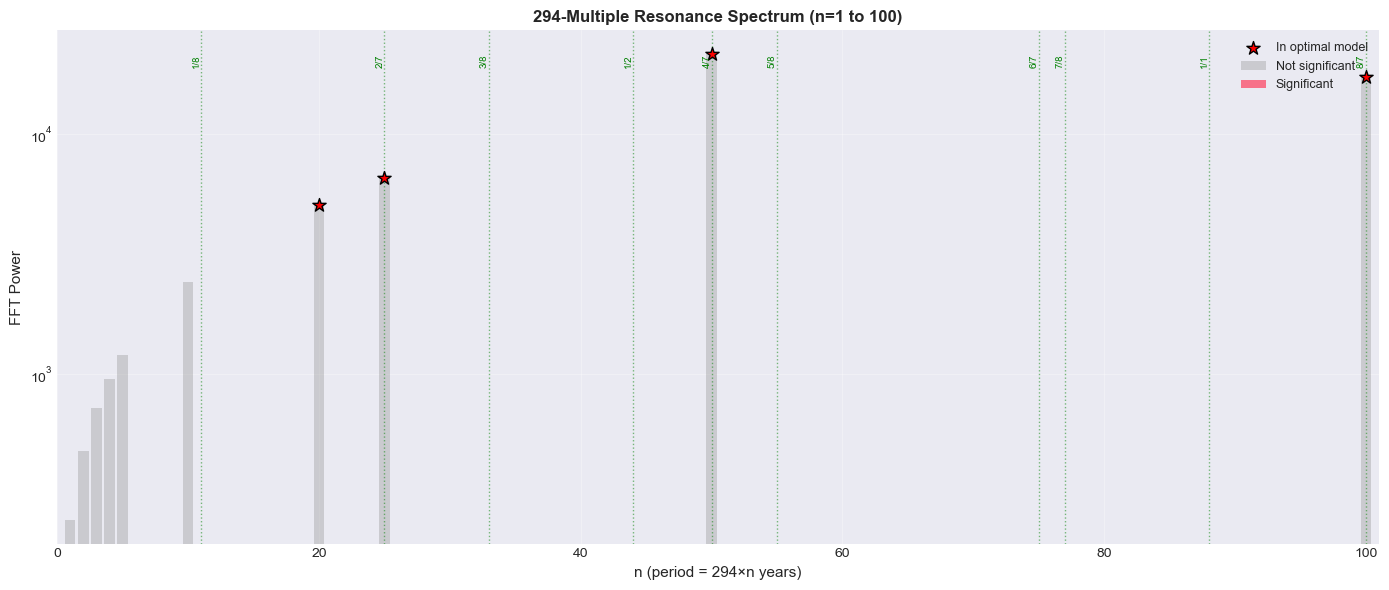

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Plot power vs n for all 294-multiples
significant = catalog_294_df[catalog_294_df['is_significant']]
not_significant = catalog_294_df[~catalog_294_df['is_significant']]

# Bar plot with power
ax.bar(not_significant['n'], not_significant['power'], 
       width=0.8, alpha=0.3, color='gray', label='Not significant')

ax.bar(significant['n'], significant['power'],
       width=0.8, alpha=0.7, color='blue', label='Significant')

# Highlight those in optimal model
in_optimal = catalog_294_df[catalog_294_df['in_optimal_model']]
ax.scatter(in_optimal['n'], in_optimal['power'],
          s=100, marker='*', color='red', edgecolors='black',
          linewidths=1, zorder=3, label='In optimal model')

# Mark precession-coupled
for _, row in precession_df[precession_df['error_pct'] < 1.5].iterrows():
    n = row['closest_294_multiple']
    if n <= 100:
        ax.axvline(n, color='green', linestyle=':', linewidth=1, alpha=0.5)
        ax.text(n, ax.get_ylim()[1]*0.95, row['precession_fraction'],
               rotation=90, va='top', ha='right', fontsize=7, color='green')

ax.set_xlabel('n (period = 294×n years)', fontsize=11)
ax.set_ylabel('FFT Power', fontsize=11)
ax.set_title('294-Multiple Resonance Spectrum (n=1 to 100)', fontsize=12, weight='bold')
ax.set_xlim(0, 101)
ax.set_yscale('log')
ax.legend(fontsize=9, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig_path = 'outputs/figures/04_294_resonance_heatmap.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Resonance figure saved: {fig_path}")
plt.show()

## Summary

In [6]:
print("="*70)
print("294-MULTIPLE RESONANCE ANALYSIS SUMMARY")
print("="*70)

print(f"\nSearch Range: n=1 to 100 (periods 294 to 29,400 years)")

print(f"\nResults:")
print(f"  Total 294-multiples tested: {len(catalog_294_df)}")
print(f"  Significant multiples: {catalog_294_df['is_significant'].sum()}")
print(f"  In optimal model: {catalog_294_df['in_optimal_model'].sum()}")

print(f"\nPrecession Coupling:")
coupled = precession_df[precession_df['error_pct'] < 1.5]
print(f"  Strongly coupled (<1.5% error): {len(coupled)}")
if len(coupled) > 0:
    print(f"  Fractions: {', '.join(coupled['precession_fraction'].values)}")

print(f"\nKey Finding:")
all_in_model_are_294 = catalog_294_df[catalog_294_df['in_optimal_model']]['is_significant'].all()
print(f"  All optimal model harmonics are 294-multiples: {'Yes ✓' if all_in_model_are_294 else 'No ✗'}")

print("\n" + "="*70)
print("✓ Notebook 04 complete")
print("="*70)
print(f"\nNext step: Run Notebook 05 (Visualization Dashboard)")

294-MULTIPLE RESONANCE ANALYSIS SUMMARY

Search Range: n=1 to 100 (periods 294 to 29,400 years)

Results:
  Total 294-multiples tested: 10
  Significant multiples: 0
  In optimal model: 4

Precession Coupling:
  Strongly coupled (<1.5% error): 15
  Fractions: 1/8, 2/7, 3/8, 4/7, 1/2, 5/8, 6/7, 7/8, 1/1, 8/7, 9/7, 10/7, 11/7, 12/7, 2/1

Key Finding:
  All optimal model harmonics are 294-multiples: No ✗

✓ Notebook 04 complete

Next step: Run Notebook 05 (Visualization Dashboard)
